In [10]:

# libries for data preparation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# libries for data analysis
import os

# libraries for clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# libraries for scaling
from sklearn.preprocessing import StandardScaler

# libraries for encoding, this is to reduce the number of features compared with the normal one-hot encoding
import category_encoders as ce

# libraries for spilitting data
from sklearn.model_selection import train_test_split

# libraries for sampler
from imblearn.over_sampling import SVMSMOTE

# libraries for feature selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

# libraries for transformation and decomposition
from scipy.special import inv_boxcox
from scipy.stats import boxcox 

# libraries for feature reduction
from sklearn.decomposition import PCA

# import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import f1_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import classification_report, confusion_matrix,\
roc_auc_score, roc_curve, precision_recall_curve, fbeta_score, recall_score,\
precision_recall_fscore_support

# libraries for models
# classification
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# regression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

# libraries for hyperparameter tuning
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# libries for significant figures
from sigfig import round

from IPython import display

# avoid future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# avoid convergence warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter(action='ignore', category=ConvergenceWarning)

# avoid UserWarning
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Data class

In [3]:
class Data():
    
    def __init__(self, data_path, file_name, random_state=33):
        self.data_path = data_path
        self.file_name = file_name
        self.random_state = random_state
        self.features = None
        self.target = None
        self.label_for_test = None
        self.data = self._load_data(self.data_path, self.file_name)
        self.scaler = StandardScaler()
        self.feature_selector = SelectKBest(f_classif, k=5)
        self.sampler = SVMSMOTE(random_state=self.random_state)
        
    def _load_data(self, data_path, file_name):
        try:
            full_path = os.path.join(data_path, file_name)
            self.data = pd.read_excel(full_path, header=1)
            csv_file_name = file_name.replace(" ", "_")
            csv_path = os.path.join(data_path, csv_file_name[:-5] + ".csv")
            self.data.to_csv(csv_path, index=False)
            self.data = pd.read_csv(csv_path)
            return self.data
        except FileNotFoundError:
            raise FileNotFoundError(f"File {file_name} not found in {data_path}")
        except IOError as e:
            raise IOError(f"Error reading file {file_name}: {e}")
    
    def get_data(self):
        return self.data
    
    def data_summary(self, interactive=False):
        hashtable = {
            "shape": self.data.shape,
            "columns": self.data.columns,
            "data types": self.data.dtypes,
            "missing values": self.data.isnull().sum(),
            "unique values": self.data.nunique(),
            "count": self.data.count()
        }
        if interactive:
            for key, value in hashtable.items():
                print(f"{key}: {value}")
        
        return hashtable
    
    def _data_cleaning(self) -> pd.DataFrame:
        hashtable = {
        'PAY_0': 'Repayment_Status_Sept',
        'PAY_2': 'Repayment_Status_Aug',
        'PAY_3': 'Repayment_Status_Jul',
        'PAY_4': 'Repayment_Status_Jun',
        'PAY_5': 'Repayment_Status_May',
        'PAY_6': 'Repayment_Status_Apr',
        'BILL_AMT1': 'Bill_Amount_Sept',
        'BILL_AMT2': 'Bill_Amount_Aug',
        'BILL_AMT3': 'Bill_Amount_Jul',
        'BILL_AMT4': 'Bill_Amount_Jun',
        'BILL_AMT5': 'Bill_Amount_May',
        'BILL_AMT6': 'Bill_Amount_Apr',
        'PAY_AMT1': 'Pay_Amount_Sept',
        'PAY_AMT2': 'Pay_Amount_Aug',
        'PAY_AMT3': 'Pay_Amount_Jul',
        'PAY_AMT4': 'Pay_Amount_Jun',
        'PAY_AMT5': 'Pay_Amount_May',
        'PAY_AMT6': 'Pay_Amount_Apr',
        'default payment next month': 'Default_Payment'
        }
        # drop ID column, as it is not useful for prediction
        self.data.drop(["ID"], axis=1, inplace=True)
        # replace the missing values with the -1
        self.data["EDUCATION"].replace({0: -1, 4: -1, 5: -1, 6: -1}, inplace=True)
        self.data['MARRIAGE'].replace({0: -1, 3: -1}, inplace=True)
        # rename the columns
        self.data.rename(columns=hashtable, inplace=True)
        # remove outliers
        self.data = self._reg_handle_outliers("LIMIT_BAL")
        self.data = self.data.groupby('LIMIT_BAL').filter(lambda x: len(x) > 30)
        self.data.to_csv('../data/cleaned_data.csv', index=False)
        return self.data
    
    def data_visualization(self, col_name,target_name):
        print(self.data.groupby(col_name)[target_name].mean())
        sns.countplot(x=col_name, hue=target_name, data=self.data)
        plt.show()
        return None
    
    def check_outliers(self,col_name:str):
        data_info = self.data[col_name].describe()
        unique_value = df[col_name].unique()
        count_unique_value = df["LIMIT_BAL"].value_counts().sort_values(ascending=True)
        return data_info, unique_value, count_unique_value
    
    def correlation(self):
        # reference: Lab resource, CreditCardFraud.ipynb
        sns.set_theme(style="white")
        corr = self.data.corr()
        mask = np.triu(np.ones_like(corr, dtype=bool))
        f, ax = plt.subplots(figsize=(11, 9))
        cmap = sns.diverging_palette(230, 20, as_cmap=True)
        sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                    square=True, linewidths=.5, cbar_kws={"shrink": .5})
        return None
    
    def check_skewness(self):
        self.data.skew()
        return None
    
    def check_number_of_categories(self, col_name):
        count_category = df.groupby(col_name).size()
        pert_category = df.groupby(col_name).size()/len(df)
        return count_category, pert_category
    
    def data_distribution(self, col_name=None, target_name="default payment next month"):
        if col_name == None:
            self.data.hist(figsize=(20, 20))
        else:
            df[df["default payment next month"]==1][col_name].hist()
        return None
    
    def check_distribution(self, col_name):
        # Set up a figure with two subplots
        fig, axs = plt.subplots(2, 1, figsize=(10, 12))

        # Title for the whole figure
        fig.suptitle(f"Distribution and Boxplot of {col_name}", fontsize=16)

        # Distribution plot in the first subplot
        sns.distplot(self.data[col_name], ax=axs[0])
        axs[0].set_title(f"Distribution of {col_name}")

        # Boxplot in the second subplot
        sns.boxplot(x=self.data[col_name], ax=axs[1])
        axs[1].set_title(f"Boxplot of {col_name}")

        # Adjust layout to prevent overlap
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])

        # Show the plots
        plt.show()
    
        return None
    
    # Feature Engineering
    def cluster_group(self, col_name, min_k=5, max_k=5, scaler=StandardScaler()) -> pd.DataFrame:
        features_for_clustering = self.data[[col_name]]
        features_for_clustering = scaler.fit_transform(features_for_clustering)
        best_score = -1
        best_k = 0
        for k in range(min_k, max_k+1):
            kmeans = KMeans(n_clusters=k, random_state=self.random_state)
            kmeans.fit(features_for_clustering)
            score = silhouette_score(features_for_clustering, kmeans.labels_)
            if score > best_score:
                best_score = score
                best_k = k
        best_kmeans = KMeans(n_clusters=best_k, random_state=self.random_state)
        self.data[f"{col_name}_cluster"] = best_kmeans.fit_predict(features_for_clustering)
        return self.data

    def create_new_feature(self, min_k=5, max_k=10) -> pd.DataFrame:
        
        # create new features via aggregation
        self.data['Bill_Amount_Total'] = self.data['Bill_Amount_Sept'] + self.data['Bill_Amount_Aug'] + self.data['Bill_Amount_Jul'] + self.data['Bill_Amount_Jun'] + self.data['Bill_Amount_May'] + self.data['Bill_Amount_Apr']
        self.data['Pay_Amount_Total'] = self.data['Pay_Amount_Sept'] + self.data['Pay_Amount_Aug'] + self.data['Pay_Amount_Jul'] + self.data['Pay_Amount_Jun'] + self.data['Pay_Amount_May'] + self.data['Pay_Amount_Apr']
        self.data['Bill_Amount_Average'] = self.data['Bill_Amount_Total'] / 6
        self.data['Pay_Amount_Average'] = self.data['Pay_Amount_Total'] / 6
        self.data['Repayment_Status_Total'] = self.data['Repayment_Status_Sept'] + self.data['Repayment_Status_Aug'] + self.data['Repayment_Status_Jul'] + self.data['Repayment_Status_Jun'] + self.data['Repayment_Status_May'] + self.data['Repayment_Status_Apr']
        self.data['Repayment_Status_Average'] = self.data['Repayment_Status_Total'] / 6
        
        # Avoid multicollinearity
        self.data = self.data.drop(['Bill_Amount_Sept', 'Bill_Amount_Aug', 'Bill_Amount_Jul', 'Bill_Amount_Jun', 'Bill_Amount_May', 'Bill_Amount_Apr'], axis=1)
        self.data = self.data.drop(['Pay_Amount_Sept', 'Pay_Amount_Aug', 'Pay_Amount_Jul', 'Pay_Amount_Jun', 'Pay_Amount_May', 'Pay_Amount_Apr'], axis=1)
        self.data = self.data.drop(['Repayment_Status_Sept', 'Repayment_Status_Aug', 'Repayment_Status_Jul', 'Repayment_Status_Jun', 'Repayment_Status_May', 'Repayment_Status_Apr'], axis=1)
        
        # create new features via clustering
        self.data = self.cluster_group('Bill_Amount_Total', min_k=min_k, max_k=max_k)
        self.data = self.cluster_group('Bill_Amount_Average', min_k=min_k, max_k=max_k)
        self.data = self.cluster_group('Pay_Amount_Total', min_k=min_k, max_k=max_k)
        self.data = self.cluster_group('Pay_Amount_Average', min_k=min_k, max_k=max_k)
        self.data = self.cluster_group('Repayment_Status_Total', min_k=min_k, max_k=max_k)
        self.data = self.cluster_group('Repayment_Status_Average', min_k=min_k, max_k=max_k)
        self.data = self.cluster_group('AGE', min_k=min_k, max_k=max_k)
        
        self.data.to_csv('../data/clustered_data.csv', index=False)
        return self.data
    
    def _prepare_feature_target(self, target_name, reg_features=None, classify=True):
        
        if classify:
            self.features = self.data.drop([target_name], axis=1)
            self.target = self.data[target_name]
            self.target = pd.DataFrame(self.target)
        else:
            self.features = self.data[reg_features]
            self.target = self.data[target_name]
            self.target = pd.DataFrame(self.target)
        return self.features, self.target
    
    def _different_categories_numerical(self):
        categories = []
        numerical = []
        for col in self.features.columns:
            unique_values = self.data[col].unique()
            if len(unique_values) <= 11:
                categories.append(col)
            else:
                numerical.append(col)
        return categories, numerical
    
    def _apply_binary_ohe(self, categorical_columns):
        encoder = ce.BinaryEncoder(cols=categorical_columns)
        self.features = encoder.fit_transform(self.features)
        return self.features
        
    # Continue feature engineering for regression
    
    def _reg_handle_outliers(self, col_name:str) -> pd.DataFrame:
        Q1 = self.data[col_name].quantile(0.25)
        Q3 = self.data[col_name].quantile(0.75)
        IQR = Q3 - Q1
        lower_limit = Q1 - 1.5 * IQR
        upper_limit = Q3 + 1.5 * IQR
        self.data = self.data[(self.data[col_name] > lower_limit) & (self.data[col_name] < upper_limit)]
    
        return self.data
    
    def _reg_create_new_feature(self):
        # create new features
        self.features = self.features.copy()
        self.features['Edu_Marrige'] = self.features['EDUCATION'] * self.features['MARRIAGE']
        self.features['Edu_Marrige2'] = self.features['EDUCATION'] * self.features['MARRIAGE'] ** 2
        self.features['Edu_Age2'] = self.features['EDUCATION'] * self.features['AGE_cluster'] ** 2
        self.features['Edu3_Sex'] = self.features['EDUCATION'] ** 3 * self.features['SEX']
        self.features["Edu3"] = self.features["EDUCATION"] ** 3
        self.features["Marriage4"] = self.features["MARRIAGE"] ** 4
        self.features["Marriage_Age3"] = self.features["MARRIAGE"] * self.features["AGE_cluster"] ** 3
        self.features["Sex_edu3_mar"] = self.features["SEX"] * self.features["EDUCATION"] ** 3 * self.features["MARRIAGE"]
        self.features["Sex2_mar_age2"] = self.features["SEX"] ** 2 * self.features["MARRIAGE"] * self.features["AGE_cluster"] ** 2
        self.features['Edu3_mar2_age'] = self.features["EDUCATION"]**3 * self.features["MARRIAGE"]**2 * self.features["AGE_cluster"]
        return self.features
    
    def _reg_feature_engineering(self, target_name="Default_Payment", reg_features=None, classify=True):
        # remove outliers
        category_features = ["SEX", "EDUCATION", "MARRIAGE"]
        self.features, self.target = self._prepare_feature_target(target_name, reg_features, classify=False)
        self.features = self._reg_create_new_feature()
        self.label_for_train = self.target["LIMIT_BAL"]
        self.label_for_test = self.target["Default_Payment"]
        self.features = self._apply_binary_ohe(category_features)
        
        return self.features, self.label_for_train, self.label_for_test
    
    def _cls_feature_engineering(self, target_name, reg_features=None, classify=True):
        self.features, self.target = self._prepare_feature_target(target_name, reg_features, classify)
        categorical_columns, numerical_columns = self._different_categories_numerical()
        self.features = self._apply_binary_ohe(categorical_columns)
        return self.features, self.target
        
    def prepare_data(self, target_name, reg_features=None, classify=True):
        # if cleaned_data.csv and clustered_data.csv exist, then load them
        if os.path.exists('../data/clustered_data.csv') and os.path.exists('../data/cleaned_data.csv'):
            self.data = pd.read_csv('../data/clustered_data.csv')
            self.data = pd.DataFrame(self.data)
        else:
            self.data = self._data_cleaning()
            self.data = self.create_new_feature()
        if not classify:
            self.features, self.label_for_train, self.label_for_test = self._reg_feature_engineering(target_name=target_name, reg_features=reg_features, classify=classify)
            return self.features, self.label_for_train, self.label_for_test
        else:
            self.features, self.target = self._cls_feature_engineering(target_name, reg_features, classify)
            self.target = self.target[target_name]
            return self.features, self.target

    def split_data(self, test_size=0.2, classify=True):
        
        if classify:
            features_cls, target_cls = self.prepare_data("Default_Payment", classify=True)
            X_train, X_test, y_train, y_test = train_test_split(features_cls, target_cls, test_size=test_size, random_state=self.random_state)

            X_train_scaled = self.scaler.fit_transform(X_train)
            X_test_scaled = self.scaler.transform(X_test)

            X_train_resampled, y_train_resampled = self.sampler.fit_resample(X_train_scaled, y_train)

            X_train_selected = self.feature_selector.fit_transform(X_train_resampled, y_train_resampled)
            X_test_selected = self.feature_selector.transform(X_test_scaled)

            n_features = X_train_selected.shape[1]

            if n_features > 1:
                pca = PCA(n_components=min(n_features, 2))
                X_train_pca = pca.fit_transform(X_train_selected)
                X_test_pca = pca.transform(X_test_selected)
            else:
                X_train_pca = X_train_selected
                X_test_pca = X_test_selected

            return X_train_pca, X_test_pca, y_train_resampled, y_test
        
        else:
            feature_reg, label_for_train, label_for_test = data.prepare_data(target_name=["LIMIT_BAL", "Default_Payment"], reg_features=["SEX", "EDUCATION", "MARRIAGE", "AGE_cluster"],classify=False)
            train_X, test_X, train_y, test_y, _ , test_y_additional = train_test_split(self.features, self.label_for_train, self.label_for_test, test_size=test_size, random_state=self.random_state)
            
            train_X_scaled = self.scaler.fit_transform(train_X)
            test_X_scaled = self.scaler.transform(test_X)
            
            train_y_transformed, lambda_ = boxcox(train_y)
            
            return train_X_scaled, test_X_scaled, train_y_transformed, test_y, lambda_, test_y_additional
            

# Model

In [12]:
class CustomScorer:
        
    def __init__(self, additional_data):
        self.additional_data = additional_data

    def __call__(self, estimator, X, y_true):
        y_pred = estimator.predict(X)
        return self._reg_custom_score(y_pred, y_true, self.additional_data)

    def _reg_custom_score(self, y_pred, y_true, test_y_additional):
        hits = 0
        total = len(y_true)
        for i in range(total):
            y_pred_value = y_pred[i]
            y_true_value = y_true[i]
            test_y_additional_value = test_y_additional.iloc[i]

            if test_y_additional_value == 1 and y_pred_value < y_true_value:
                hits += 1
            elif test_y_additional_value == 0:
                if y_pred_value <= y_true_value or (y_pred_value > y_true_value and y_pred_value - y_true_value <= 30000):
                    hits += 1
        return hits / total if total > 0 else 0
        
class Model:
    def __init__(self, model, random_state=33, params=None):
        self.model = model
        self.random_state = random_state
        self.model_name = str(model).split("(")[0]
        self.model_params = params if params is not None else {}
        self.model.set_params(**self.model_params)
        self.random_state = random_state
        self.model_report = []
        
        self.benefit_tp = 60
        self.cost_fp = 40
        self.cost_fn = 55
        self.benefit_tn = 10
    
    def _fit(self, X, y):
        self.model.fit(X, y)
        return self.model
    
    def _predict(self, X):
        return self.model.predict(X)
    
    # Classification
    def _train_cls_model(self, X_train, X_test, y_train, y_test):
        self.model.fit(X_train, y_train)
        return None
    
    def _cls_model_score(self, X_test, y_test):
        return self.model.score(X_test, y_test)
    
    def _cls_model_accuracy(self, y_pred, y_test):
        accuracy = accuracy_score(y_pred, y_test)
        return accuracy
    
    def _cls_model_confusion_matrix(self, y_pred, y_test):
        cm = confusion_matrix(y_pred, y_test)
        return cm
    
    def _cls_model_recall(self, y_pred, y_test):
        recall = recall_score(y_pred, y_test)
        return recall
    
    def _cls_model_f1_score(self, y_pred, y_test):
        f1 = f1_score(y_pred, y_test)
        return f1
    
    def _cls_model_flase_positive_rate(self, y_pred, y_test):
        fpr = roc_curve(y_pred, y_test)[0][1]
        return fpr
    
    def _cls_model_classification_report(self, y_pred, y_test):
        cr = classification_report(y_pred, y_test)
        return cr
    
    def _cls_model_roc_auc_score(self, y_pred, y_test):
        roc_auc = roc_auc_score(y_pred, y_test)
        return roc_auc
    
    def _cls_profit_value(self, cm):
        tp = cm[0][0]
        fp = cm[0][1]
        fn = cm[1][0]
        tn = cm[1][1]
        total_profit = (tp * self.benefit_tp) - (fp * self.cost_fp) - (fn * self.cost_fn) + (tn * self.benefit_tn)
        return total_profit
    
    def cls_model_report(self, X_train, X_test, y_train, y_test):
        self._train_cls_model(X_train, X_test, y_train, y_test)
        y_pred = self.model.predict(X_test)
        score = self._cls_model_score(X_test, y_test)
        accuracy = self._cls_model_accuracy(y_pred, y_test)
        cm = self._cls_model_confusion_matrix(y_test, y_pred)
        roc_auc = self._cls_model_roc_auc_score(y_test, y_pred)
        total_profit = self._cls_profit_value(cm)
        f1 = self._cls_model_f1_score(y_test, y_pred)
        recall = self._cls_model_recall(y_test, y_pred)
        hashtable = {
            "name": self.model_name,
            "parameters": self.model_params,
            "confusion_matrix": cm,
            "roc_auc_score": roc_auc,
            "total_profit": total_profit,
            "f1_score": f1,
            "recall": recall
        }
        self.model_report.append(hashtable)
        return self.model_report
    
    # Regression
    def _train_reg_model(self, X_train, y_train):
        self.model.fit(X_train, y_train)
        return None
    
    def _reg_model_rmse(self, y_pred, y_test):
        rmse = np.sqrt(mean_squared_error(y_pred, y_test))
        return rmse
    
    def _reg_model_r2(self, y_pred, y_test):
        r2 = r2_score(y_pred, y_test)
        return r2
    
    def _reg_calculate_bias(self, y_pred, y_test):
        bias = np.mean(y_pred - y_test)
        return bias
    
    def _reg_calculate_variance(self, y_pred):
        variance = np.var(y_pred)
        return variance
    
    def _reg_model_hit_rate(self, y_pred, test_y_additional, y_test):
        hits = 0
        total = len(y_test)
        for i in range(total):
            # Use .iloc for position-based indexing
            y_pred_value = y_pred[i]
            y_test_value = y_test.iloc[i]
            test_y_additional_value = test_y_additional.iloc[i]

            # Your existing logic
            if test_y_additional_value == 1 and y_pred_value < y_test_value:
                hits += 1
            elif test_y_additional_value == 0:
                if y_pred_value <= y_test_value or (y_pred_value > y_test_value and y_pred_value - y_test_value <= 30000):
                    hits += 1

        return hits / total if total > 0 else 0
    
    def reg_model_report(self, X_train, X_test, y_train, y_test, test_y_additional, lambda_):
        self._train_reg_model(X_train, y_train)
        y_pred = self.model.predict(X_test)
        y_pred_transformed = inv_boxcox(y_pred, lambda_)
        y_pred_transformed = [round(val, 2) for val in y_pred_transformed]
        
        rmse = np.sqrt(mean_squared_error(y_test, y_pred_transformed))
        mae = mean_absolute_error(y_test, y_pred_transformed)
        r2 = r2_score(y_test, y_pred_transformed)
        hit_rate = self._reg_model_hit_rate(y_pred_transformed, test_y_additional, y_test)
        bias = self._reg_calculate_bias(y_pred_transformed, y_test)
        variance = self._reg_calculate_variance(y_pred_transformed)
        
        hashtable = {
            "name": self.model_name,
            "parameters": self.model_params,
            "rmse": round(rmse, 2),
            "mae": round(mae, 2),
            "r2": r2,
            "hit_rate": str(round(hit_rate * 100, 4)) + "%",
            "bias": round(bias, 2),
            "variance": round(variance, 2)
        }
        self.model_report.append(hashtable)
        return self.model_report
    
    def cls_custom_score(self, y_pred, y_test):
        cm = confusion_matrix(y_pred, y_test)
        profit_value = self._cls_profit_value(cm)
        return profit_value
    
    def tune_parameters_cls(self, X, y, tuning_method='grid', param_grid=None, cv=5, n_iter=10):
        scorer = make_scorer(self.cls_custom_score)
        if tuning_method == 'grid':
            self.tuner = GridSearchCV(self.model, param_grid, scoring=scorer, cv=cv, verbose=3)
        elif tuning_method == 'random':
            self.tuner = RandomizedSearchCV(self.model, param_grid, scoring=scorer, n_iter=n_iter, cv=cv, random_state=self.random_state, verbose=3)
            
        self.tuner.fit(X, y)
        self.best_params = self.tuner.best_params_
        self.model.set_params(**self.best_params)
        return self.best_params

    def tune_parameters_reg(self, X, y, test_y_additional, tuning_method='grid', param_grid=None, cv=5, n_iter=10):
        custom_scorer = CustomScorer(test_y_additional)
        if tuning_method == 'grid':
            self.tuner = GridSearchCV(self.model, param_grid, scoring=custom_scorer, cv=cv, verbose=3)
        elif tuning_method == 'random':
            self.tuner = RandomizedSearchCV(self.model, param_grid, scoring=custom_scorer, n_iter=n_iter, cv=cv, random_state=self.random_state, verbose=3)
        
        self.tuner.fit(X, y)
        self.best_params = self.tuner.best_params_
        self.model.set_params(**self.best_params)
        return self.best_params
    
    def plot_tuning_results(self):
        # Ensure the tuning has been completed
        if hasattr(self, 'tuner') and hasattr(self.tuner, 'cv_results_'):
            results = pd.DataFrame(self.tuner.cv_results_)
            # Example: Plotting mean test score for each parameter combination
            plt.figure(figsize=(10, 6))
            results['mean_test_score'].plot(kind='bar')
            plt.title('Hyperparameter Tuning Results')
            plt.xlabel('Parameter Combination Index')
            plt.ylabel('Mean Test Score')
            plt.show()
        else:
            print("Tuning has not been completed yet or no results are available.")

In [17]:
class Evaluation():
    
    def __init__(self, model_reports=[]):
        # Initialize with an optional list of model reports
        self.model_reports = []
        
    def add_model_report(self, new_report):
        # Adds a new model report to the list
        self.model_reports.append(new_report)
    
    def _get_model_report(self):
        return self.model_reports
    
    def _plot_metric_bar_chart_cls(self):
        model_names = []
        f1_scores = []
        recalls = []
        roc_aucs = []
        false_negative_rates = []
        
        # Extracting data
        for report_list in self.model_reports:
            for report in report_list:
                model_names.append(report['name'])
                f1_scores.append(report['f1_score'])
                recalls.append(report['recall'])
                roc_aucs.append(report['roc_auc_score'])
                false_negative_rates.append(report['confusion_matrix'][1][0] / sum(report['confusion_matrix'][1]))
        
        # Number of models
        n_models = len(model_names)
        
        # Create bar locations
        barWidth = 0.25
        r1 = np.arange(n_models)
        r2 = [x + barWidth for x in r1]
        r3 = [x + barWidth for x in r2]
        r4 = [x + barWidth for x in r3]
        
        # Plotting
        plt.figure(figsize=(12, 6))
        
        # Create bars
        plt.bar(r1, f1_scores, color='skyblue', width=barWidth, edgecolor='grey', label='F1 Score')
        plt.bar(r2, recalls, color='lightgreen', width=barWidth, edgecolor='grey', label='Recall')
        plt.bar(r3, roc_aucs, color='salmon', width=barWidth, edgecolor='grey', label='ROC AUC Score')
        plt.bar(r4, false_negative_rates, color='lightblue', width=barWidth, edgecolor='grey', label='False Negative Rate')
        
        # Add labels
        plt.xlabel('Model', fontweight='bold')
        plt.ylabel('Scores')
        plt.xticks([r + barWidth for r in range(n_models)], model_names)
        
        # Create legend & Show plot
        plt.legend()
        plt.title('Model Comparison: F1, Recall, ROC AUC, and False Negative Rate')
        plt.show()
        
    def _plot_total_profit_bar_chart(self, name):
        # Number of different reports
        num_reports = len(self.model_reports)
        
        # Create a list for total profits and model names for all reports
        all_total_profits = []
        all_names = []

        for report in self.model_reports:
            all_total_profits.append([model[name] for model in report])
            all_names.append([model["name"] for model in report])

        # The number of different models (assuming all reports have the same models)
        num_models = len(all_total_profits[0])

        # Set the width of each bar
        bar_width = 0.8 / num_reports  # Adjust this based on how many reports you have

        # Set the position of bars on the X axis
        r = np.arange(num_models)

        plt.figure(figsize=(12, 6))

        # Create bars for each report
        for i in range(num_reports):
            plt.bar(r + i * bar_width, all_total_profits[i], width=bar_width, edgecolor='grey', label=all_names[i])

        plt.ylabel('Total Estimated' + name)
        plt.title('Total Estimated' + name + 'for Each Model Across Reports')

        plt.legend()
        plt.tight_layout()
        plt.show()
    
    def _plot_hit_rate_bar_chart(self):
        model_names = []
        hit_rates = []

        for report_list in self.model_reports:  # Accessing instance variable
            for report in report_list:
                model_names.append(report['name'])
                hit_rate = float(report['hit_rate'].replace('%', ''))
                hit_rates.append(hit_rate)

        # Plotting
        plt.figure(figsize=(10, 6))
        plt.bar(model_names, hit_rates, color='skyblue')
        plt.xlabel('Model')
        plt.ylabel('Hit Rate (%)')
        plt.title('Model Hit Rates')
        plt.ylim(0, 100)  # Assuming hit rate is a percentage
        for i, rate in enumerate(hit_rates):
            plt.text(i, rate + 1, f'{rate}%', ha='center')
        plt.show()
    
    def _plot_metric_bar_chart_rg(self):
        model_names = []
        rmses = []
        maes = []
        r2s = []

        # Extracting data
        for report_list in self.model_reports:
            for report in report_list:
                model_names.append(report['name'])
                rmses.append(report['rmse'] / 1000000)  # Dividing by 1,000,000 for scaling
                maes.append(report['mae'] / 1000000)   # Dividing by 1,000,000 for scaling
                r2s.append(report['r2'])
                
        # Number of models
        n_models = len(model_names)

        # Create bar locations
        barWidth = 0.25
        r1 = np.arange(n_models)
        r2 = [x + barWidth for x in r1]
        r3 = [x + barWidth for x in r2]

        # Plotting
        plt.figure(figsize=(12, 6))

        # Create bars
        plt.bar(r1, rmses, color='skyblue', width=barWidth, edgecolor='grey', label='RMSE (in Millions)')
        plt.bar(r2, maes, color='lightgreen', width=barWidth, edgecolor='grey', label='MAE (in Millions)')
        plt.bar(r3, r2s, color='salmon', width=barWidth, edgecolor='grey', label='R2')

        # Add labels
        plt.xlabel('Model', fontweight='bold')
        plt.ylabel('Scores')
        plt.xticks([r + barWidth for r in range(n_models)], model_names)

        # Create legend & Show plot
        plt.legend()
        plt.title('Model Comparison: RMSE, MAE, and R2 Scores')
        plt.show()
    
    def _plot_bias_variance_bar_chart_rg(self):
        model_names = []
        biases = []
        variances = []
        
        # Extracting data
        for report_list in self.model_reports:
            for report in report_list:
                model_names.append(report['name'])
                biases.append(report['bias'])
                variances.append(report['variance'])
        
        # Number of models
        n_models = len(model_names)
        
        # Create bar locations
        barWidth = 0.25
        r1 = np.arange(n_models)
        r2 = [x + barWidth for x in r1]
        
        # Plotting
        plt.figure(figsize=(12, 6))
        
        # Create bars
        plt.bar(r1, biases, color='skyblue', width=barWidth, edgecolor='grey', label='Bias')
        plt.bar(r2, variances, color='lightgreen', width=barWidth, edgecolor='grey', label='Variance')
        
        # Add labels
        plt.xlabel('Model', fontweight='bold')
        plt.ylabel('Scores')
        plt.xticks([r + barWidth for r in range(n_models)], model_names)
        
        # Create legend & Show plot
        plt.legend()
        plt.title('Model Comparison: Bias and Variance')
        plt.show()

    def _confusion_matrix_heatmap(self):
        total_num_models = sum(len(report) for report in self.model_reports)
    
        # Create a subplot for each model in all reports
        fig, axes = plt.subplots(1, total_num_models, figsize=(15 * total_num_models, 10))
        if total_num_models == 1:
            axes = [axes]  # Ensure axes is always a list

        current_axis = 0
        for report in self.model_reports:
            for model in report:
                print(model['name'], "confusion matrix:\n", model['confusion_matrix'])  # Debugging line
                sns.heatmap(model['confusion_matrix'], annot=True, fmt='d', ax=axes[current_axis],cmap='viridis', annot_kws={"size": 20})
                axes[current_axis].set_title(model['name'], fontsize=20)
                axes[current_axis].set_xlabel('Predicted Labels', fontsize=20)
                axes[current_axis].set_ylabel('True Labels', fontsize=20)
                axes[current_axis].tick_params(axis='both', which='major', labelsize=15)
                current_axis += 1
        plt.tight_layout()
        plt.show()

    def visualize_model_reports(self, classfy=True):
        if classfy:
            self._plot_total_profit_bar_chart("total_profit")
            self._confusion_matrix_heatmap()
            self._plot_metric_bar_chart_cls()
        else:
            self._plot_hit_rate_bar_chart()
            self._plot_metric_bar_chart_rg()
            self._plot_bias_variance_bar_chart_rg()

In [14]:
class Pipeline(Model):
    
    def __init__(self, model, random_state=None, params=None):
        super().__init__(model, random_state, params)
        self.best_params = None
        self.model_report = []
    
    def _find_best_parameters_cls(self, X, y, tuning_method='grid', param_grid=None, cv=5, n_iter=10):
        print("Starting parameter tuning for classification model...")
        self.tune_parameters_cls(X, y, tuning_method, param_grid, cv, n_iter)
        print("Parameter tuning completed.")
        return self.best_params
    
    def _find_best_parameters_reg(self, X, y, test_y_additional, tuning_method='grid', param_grid=None, cv=5, n_iter=10):
        print("Starting parameter tuning for regression model...")
        self.tune_parameters_reg(X, y, test_y_additional, tuning_method, param_grid, cv, n_iter)
        print("Parameter tuning completed.")
        return self.best_params
    
    def _find_cls_report(self, X_train, X_test, y_train, y_test):
        print("Generating classification model report...")
        report = self.cls_model_report(X_train, X_test, y_train, y_test)
        print("Classification model report generated.")
        return report
    
    def _find_reg_report(self, X_train, X_test, y_train, y_test, test_y_additional, lambda_):
        print("Generating regression model report...")
        report = self.reg_model_report(X_train, X_test, y_train, y_test, test_y_additional, lambda_)
        print("Regression model report generated.")
        return report
    
    def start_pipeline_cls(self, X_train, X_test, y_train, y_test, tuning_method='grid', param_grid=None, cv=5, n_iter=10):
        print("Starting classification pipeline...")
        self._find_best_parameters_cls(X_train, y_train, tuning_method, param_grid, cv, n_iter)
        self._find_cls_report(X_train, X_test, y_train, y_test)
        print("Classification pipeline completed.")
        return self.model_report
    
    def start_pipline_reg(self, X_train, X_test, y_train,y_test, test_y_additional, lambda_, tuning_method='grid', param_grid=None, cv=5, n_iter=10):
        print("Starting regression pipeline...")
        self._find_best_parameters_reg(X_train, y_train, test_y_additional, tuning_method, param_grid, cv, n_iter)
        self._find_reg_report(X_train, X_test, y_train, y_test, test_y_additional, lambda_)
        print("Regression pipeline completed.")
        return self.model_report


In [5]:
data = Data("../data/", "default of credit card clients.xls", random_state=33)
cls_X_train, cls_X_test, cls_y_train, cls_y_test = data.split_data(test_size=0.2, classify=True)
reg_X_train, reg_X_test, reg_y_train, reg_y_test, lambda_, reg_y_test_additional = data.split_data(test_size=0.2, classify=False)

In [25]:
logistic_param_grid = {
    'C': [0.01, 0.1, 10, 100],  # Regularization strength
    'max_iter': [100, 400],         # Maximum number of iterations to converge
    'penalty': ['l2'],        # Type of regularization
    'solver': ['newton-cholesky', 'lbfgs', 'liblinear', 'sag', 'saga'],  # Algorithm to use for optimization
    'max_iter': [100, 400, 600, 800, 1000],        # Maximum number of iterations to converge
    'n_jobs': [-1],           # Use all CPU cores
    'random_state': [33]     # Set random seed for reproducibility
}

cls_lr_pipeline = Pipeline(LogisticRegression(), random_state=33)
cls_lr_report = cls_lr_pipeline.start_pipeline_cls(cls_X_train, cls_X_test, cls_y_train, cls_y_test , tuning_method='grid', param_grid=logistic_param_grid, cv=5, n_iter=50)

Starting classification pipeline...
Starting parameter tuning for classification model...
Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5] END C=0.01, max_iter=100, n_jobs=-1, penalty=l2, random_state=33, solver=newton-cholesky;, score=50300.000 total time=   0.4s
[CV 2/5] END C=0.01, max_iter=100, n_jobs=-1, penalty=l2, random_state=33, solver=newton-cholesky;, score=26250.000 total time=   0.3s
[CV 3/5] END C=0.01, max_iter=100, n_jobs=-1, penalty=l2, random_state=33, solver=newton-cholesky;, score=12365.000 total time=   0.2s
[CV 4/5] END C=0.01, max_iter=100, n_jobs=-1, penalty=l2, random_state=33, solver=newton-cholesky;, score=69225.000 total time=   0.0s
[CV 5/5] END C=0.01, max_iter=100, n_jobs=-1, penalty=l2, random_state=33, solver=newton-cholesky;, score=164395.000 total time=   0.2s
[CV 1/5] END C=0.01, max_iter=100, n_jobs=-1, penalty=l2, random_state=33, solver=lbfgs;, score=50300.000 total time=   0.2s
[CV 2/5] END C=0.01, max_iter=100, n_jobs=-1, 

In [48]:
cls_lr_pipeline.best_params

{'C': 10,
 'max_iter': 100,
 'n_jobs': -1,
 'penalty': 'l2',
 'random_state': 33,
 'solver': 'saga'}

In [26]:
svm_param_grid = {
    'C': [10, 20, 30, 50],  # Regularization strength
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],        # Type of kernel function
    'gamma': ['scale', 'auto'],  # Kernel coefficient
    'degree': [2, 3, 4, 5],         # Degree of the polynomial kernel function
    'cache_size': [700],         # Size of the kernel cache
    'max_iter': [100, 150, 200, 220, 250, 270],        # Maximum number of iterations to converge
    'random_state': [33]    # Set random seed for reproducibility
}

cls_svc_pipeline = Pipeline(SVC(), random_state=33)
cls_svc_report = cls_svc_pipeline.start_pipeline_cls(cls_X_train, cls_X_test, cls_y_train, cls_y_test, tuning_method='random', param_grid=svm_param_grid, cv=5, n_iter=100)

Starting classification pipeline...
Starting parameter tuning for classification model...
Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5] END C=30, cache_size=700, degree=3, gamma=auto, kernel=linear, max_iter=100, random_state=33;, score=-143290.000 total time=   0.1s
[CV 2/5] END C=30, cache_size=700, degree=3, gamma=auto, kernel=linear, max_iter=100, random_state=33;, score=-125690.000 total time=   0.0s
[CV 3/5] END C=30, cache_size=700, degree=3, gamma=auto, kernel=linear, max_iter=100, random_state=33;, score=-112825.000 total time=   0.0s
[CV 4/5] END C=30, cache_size=700, degree=3, gamma=auto, kernel=linear, max_iter=100, random_state=33;, score=-74230.000 total time=   0.1s
[CV 5/5] END C=30, cache_size=700, degree=3, gamma=auto, kernel=linear, max_iter=100, random_state=33;, score=-203605.000 total time=   0.1s
[CV 1/5] END C=50, cache_size=700, degree=4, gamma=scale, kernel=rbf, max_iter=100, random_state=33;, score=-22040.000 total time=   0.1s
[CV 2

In [49]:
cls_svc_pipeline.best_params

{'random_state': 33,
 'max_iter': 250,
 'kernel': 'sigmoid',
 'gamma': 'auto',
 'degree': 5,
 'cache_size': 700,
 'C': 50}

In [23]:
best_param = {
    "LR": {'C': 10,'max_iter': 100, 'n_jobs': -1, 'penalty': 'l2', 'random_state': 33, 'solver': 'saga'},
    "SVC": {'random_state': 33, 'max_iter': 250, 'kernel': 'sigmoid', 'gamma': 'auto', 'degree': 5, 'cache_size': 700, 'C': 50},
    
}

{'random_state': 33,
 'max_iter': 250,
 'kernel': 'sigmoid',
 'gamma': 'auto',
 'degree': 5,
 'cache_size': 700,
 'C': 50}

In [27]:
ramdom_forestcls_param_grid = {
    'n_estimators': [100, 200, 300],  # Fewer options for the number of trees
    'criterion': ['gini', 'entropy'],  # Choose two criteria
    'min_samples_split': [2, 4],  # Fewer options for the minimum number of samples to split
    'min_samples_leaf': [1, 3],  # Fewer options for the minimum number of samples at a leaf
    'max_features': ['sqrt'],  # Only one option for the number of features to consider
    'max_depth': [10, 20, 30], # Smaller range for maximum depth of the tree
    'n_jobs': [-1] # Use all CPU cores
}

cls_forest_pipeline = Pipeline(RandomForestClassifier(), random_state=33)
cls_forest_report = cls_forest_pipeline.start_pipeline_cls(cls_X_train, cls_X_test, cls_y_train, cls_y_test, tuning_method='random', param_grid=ramdom_forestcls_param_grid, cv=5, n_iter=20)

Starting classification pipeline...
Starting parameter tuning for classification model...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200, n_jobs=-1;, score=88685.000 total time=   0.4s
[CV 2/5] END criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200, n_jobs=-1;, score=105275.000 total time=   0.4s
[CV 3/5] END criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200, n_jobs=-1;, score=119360.000 total time=   0.4s
[CV 4/5] END criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200, n_jobs=-1;, score=152525.000 total time=   0.4s
[CV 5/5] END criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200, n_jobs=-1;, score=198110.000 total ti

In [28]:
cls_lr_pipeline.best_params
cls_svc_pipeline.best_params
cls_forest_pipeline.best_params

{'n_jobs': -1,
 'n_estimators': 200,
 'min_samples_split': 4,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 10,
 'criterion': 'gini'}

In [ ]:
best_param = {
    "LR": {'C': 10,'max_iter': 100, 'n_jobs': -1, 'penalty': 'l2', 'random_state': 33, 'solver': 'saga'},
    "SVC": {'random_state': 33, 'max_iter': 250, 'kernel': 'sigmoid', 'gamma': 'auto', 'degree': 5, 'cache_size': 700, 'C': 50},
    "RFC": {'n_jobs': -1, 'n_estimators': 200, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 10, 'criterion': 'gini'},
    
}

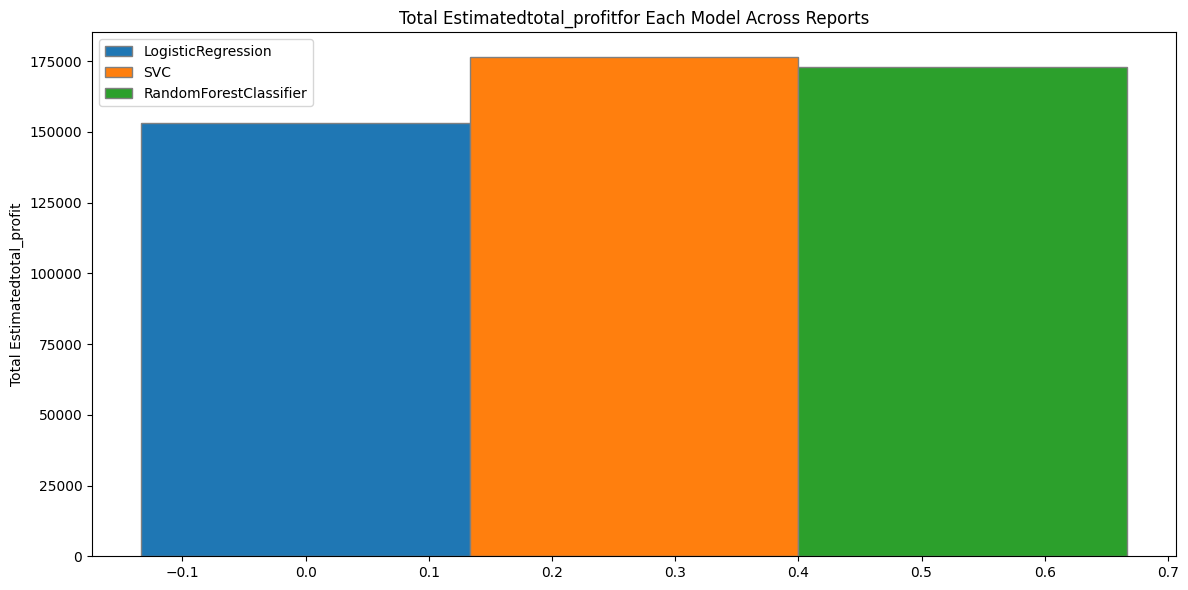

LogisticRegression confusion matrix:
 [[3727  919]
 [ 720  593]]
SVC confusion matrix:
 [[3920  726]
 [ 660  653]]
RandomForestClassifier confusion matrix:
 [[3886  760]
 [ 663  650]]


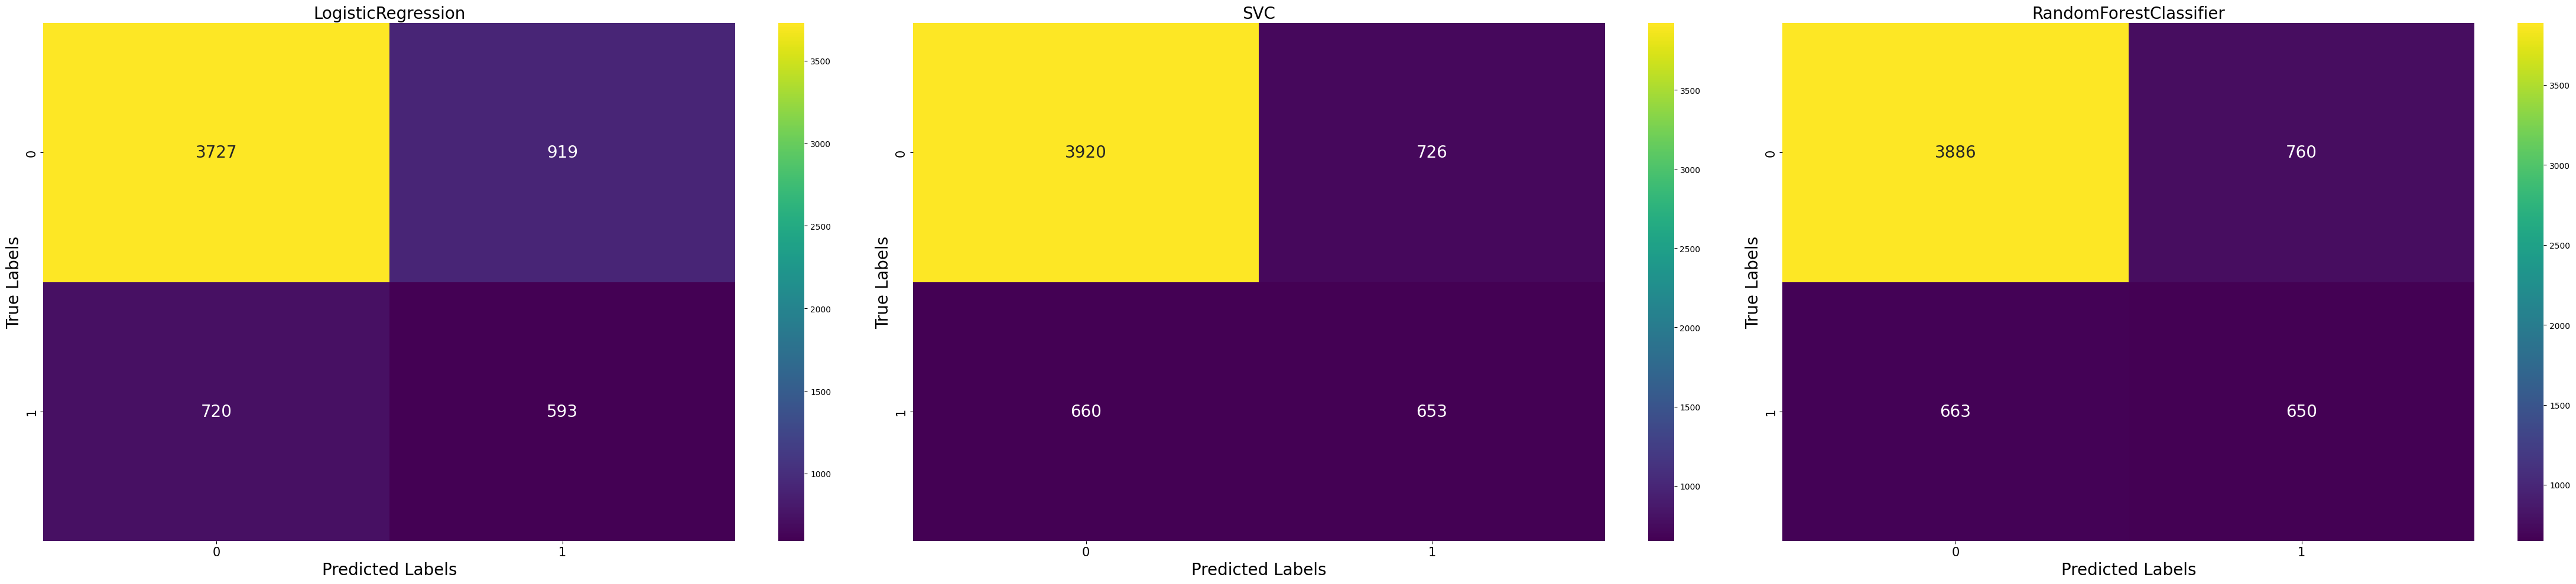

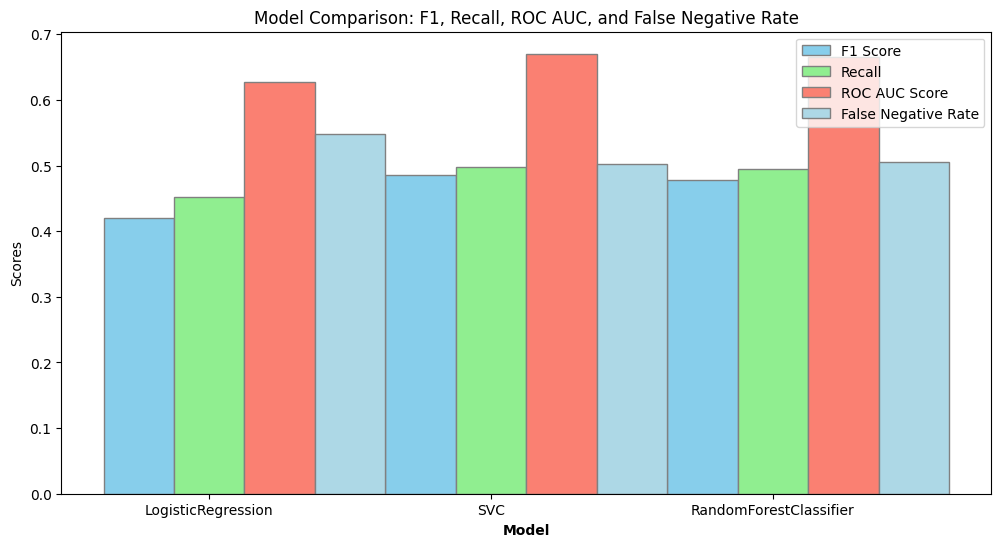

In [29]:
cls_evaluator = Evaluation()
cls_evaluator.add_model_report(cls_lr_report)
cls_evaluator.add_model_report(cls_svc_report)
cls_evaluator.add_model_report(cls_forest_report)
cls_evaluator.visualize_model_reports()

In [30]:
# import elastic net
from sklearn.linear_model import ElasticNet
regr = ElasticNet(random_state=33)

elastic_net_param_grid = {
    'selection': ['cyclic', 'random'],  # Choose two criteria
    'alpha': [0.1, 1, 10],  # Fewer options for the number of trees
    'l1_ratio': [0, 0.1, 0.5, 0.9, 1],  # Fewer options for the minimum number of samples to split
    'max_iter': [100, 200, 300, 400, 500, 1000],  # Fewer options for the minimum number of samples at a leaf
    'random_state': [33] 
}
elastic_pipeline = Pipeline(regr, random_state=33)
elastic_report = elastic_pipeline.start_pipline_reg(reg_X_train, reg_X_test, reg_y_train, reg_y_test, reg_y_test_additional, lambda_, tuning_method='grid', param_grid=elastic_net_param_grid, cv=5, n_iter=20)

Starting regression pipeline...
Starting parameter tuning for regression model...
Fitting 5 folds for each of 180 candidates, totalling 900 fits
[CV 1/5] END alpha=0.1, l1_ratio=0, max_iter=100, random_state=33, selection=cyclic;, score=0.892 total time=   0.4s
[CV 2/5] END alpha=0.1, l1_ratio=0, max_iter=100, random_state=33, selection=cyclic;, score=0.894 total time=   0.4s
[CV 3/5] END alpha=0.1, l1_ratio=0, max_iter=100, random_state=33, selection=cyclic;, score=0.894 total time=   0.4s
[CV 4/5] END alpha=0.1, l1_ratio=0, max_iter=100, random_state=33, selection=cyclic;, score=0.888 total time=   0.4s
[CV 5/5] END alpha=0.1, l1_ratio=0, max_iter=100, random_state=33, selection=cyclic;, score=0.892 total time=   0.2s
[CV 1/5] END alpha=0.1, l1_ratio=0, max_iter=100, random_state=33, selection=random;, score=0.892 total time=   0.4s
[CV 2/5] END alpha=0.1, l1_ratio=0, max_iter=100, random_state=33, selection=random;, score=0.894 total time=   0.4s
[CV 3/5] END alpha=0.1, l1_ratio=0, 

In [18]:
elastic_pipeline.best_params

{'alpha': 10, 'l1_ratio': 0.9, 'max_iter': 100, 'selection': 'cyclic'}

In [ ]:
best_param = {
    "LR": {'C': 10,'max_iter': 100, 'n_jobs': -1, 'penalty': 'l2', 'random_state': 33, 'solver': 'saga'},
    "SVC": {'random_state': 33, 'max_iter': 250, 'kernel': 'sigmoid', 'gamma': 'auto', 'degree': 5, 'cache_size': 700, 'C': 50},
    "RFC": {'n_jobs': -1, 'n_estimators': 200, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 10, 'criterion': 'gini'},
    "ElasticNet": {'alpha': 10, 'l1_ratio': 0.9, 'max_iter': 100, 'selection': 'cyclic'},
    "RFR": {'criterion': 'friedman_mse', 'max_depth': 1000, 'max_features': 'log2', 'min_samples_split': 4, 'n_estimators': 100, 'n_jobs': -1},
    "ANN": {'gamma': 0.1, 'learning_rate': 'adaptive', 'max_iter': 1000, 'random_state': 33, 'solver': 'adam'}
}

In [50]:
random_forestrf_reg_pipeline.best_params

{'criterion': 'friedman_mse',
 'max_depth': 1000,
 'max_features': 'log2',
 'min_samples_split': 4,
 'n_estimators': 100,
 'n_jobs': -1}

In [31]:
random_forestrf_param_grid = {
    'n_estimators': [100, 200, 300, 400, 600, 1000],  # Fewer options for the number of trees
    'criterion': ['mse', 'friedman_mse'],  # Choose two criteria
    'max_depth': [100, 400, 600, 800, 1000],         # Maximum number of iterations to converge
    'min_samples_split': [2, 4, 6, 8, 10],  # Fewer options for the minimum number of samples to split
    'max_features': ['sqrt', 'log2'],  # Only one option for the number of features to consider
    'n_jobs': [-1],           # Use all CPU cores
}

random_forestrf_reg_pipeline = Pipeline(RandomForestRegressor(), random_state=33)
random_forestrf_reg_report = random_forestrf_reg_pipeline.start_pipline_reg(reg_X_train, reg_X_test, reg_y_train, reg_y_test, reg_y_test_additional, lambda_, tuning_method='random', param_grid=random_forestrf_param_grid, cv=5, n_iter=50)

Starting regression pipeline...
Starting parameter tuning for regression model...
Fitting 5 folds for each of 600 candidates, totalling 3000 fits
[CV 1/5] END criterion=mse, max_depth=100, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1;, score=nan total time=   0.0s
[CV 2/5] END criterion=mse, max_depth=100, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1;, score=nan total time=   0.0s
[CV 3/5] END criterion=mse, max_depth=100, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1;, score=nan total time=   0.0s
[CV 4/5] END criterion=mse, max_depth=100, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1;, score=nan total time=   0.0s
[CV 5/5] END criterion=mse, max_depth=100, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1;, score=nan total time=   0.0s
[CV 1/5] END criterion=mse, max_depth=100, max_features=sqrt, min_samples_split=2, n_estimators=200, n_jobs=-1;, score=nan total time=   0.0s
[C

/Users/vincentzhao/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
1500 fits failed out of a total of 3000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1500 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/vincentzhao/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/vincentzhao/Library/Python/3.9/lib/python/site-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/Users/vincentzhao/Library/Python/3.9/lib/python/site-packages/sklearn/base.py", line 638, in _validate_params
 

Regression model report generated.
Regression pipeline completed.


In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

In [ ]:
best_param = {
    "LR": {'C': 10,'max_iter': 100, 'n_jobs': -1, 'penalty': 'l2', 'random_state': 33, 'solver': 'saga'},
    "SVC": {'random_state': 33, 'max_iter': 250, 'kernel': 'sigmoid', 'gamma': 'auto', 'degree': 5, 'cache_size': 700, 'C': 50},
    "RFC": {'n_jobs': -1, 'n_estimators': 200, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 10, 'criterion': 'gini'},
    "ElasticNet": {'alpha': 10, 'l1_ratio': 0.9, 'max_iter': 100, 'selection': 'cyclic'},
    "RFR": {'criterion': 'friedman_mse', 'max_depth': 1000, 'max_features': 'log2', 'min_samples_split': 4, 'n_estimators': 100, 'n_jobs': -1},
    "ANN": {'gamma': 0.1, 'learning_rate': 0.1, 'epochs': 100, 'step_size': 30, 'random_state': 33}
}

In [37]:
class ANN(nn.Module):
    
    def __init__(self, input_size, batch_size=32, learning_rate=0.1, epochs=100, step_size=30, gamma=0.1, random_state=33):
        super(ANN, self).__init__()
        # define layers
        self.fc1 = nn.Linear(input_size, 128)
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)  # 50% dropout
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(0.5)  # 50% dropout
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)
        
        # define hyperparameters
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.step_size = step_size
        self.gamma = gamma
        self.random_state = random_state
        
        # define loss and optimizer
        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        self.scheduler = StepLR(self.optimizer, step_size=step_size, gamma=gamma)
        
        # define input size
        self.input_size = input_size
        
        # define model report
        self.model_report = []
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.dropout1(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.dropout2(out)
        out = self.fc3(out)
        out = self.relu(out)
        return self.fc4(out)
    
    def _convert_data(self, data):
        if isinstance(data, pd.Series):
            data = data.to_numpy()
        data = torch.from_numpy(data).float()
        return data
    
    def training_step(self, train_X, train_y):
        train_X = self._convert_data(train_X)
        train_y = self._convert_data(train_y)
        self.train()
        plot_data = []
        for epoch in range(self.epochs):
            total_loss = 0
            for i in range(0, len(train_X), self.batch_size):
                batch_X = train_X[i:i+self.batch_size].view(-1, self.input_size)
                batch_y = train_y[i:i+self.batch_size]
                self.optimizer.zero_grad()
                outputs = self(batch_X)
                loss = self.criterion(outputs, batch_y)
                loss.backward()
                self.optimizer.step()
                total_loss += loss.item()

            # Compute average loss for the epoch
            avg_loss = total_loss / (len(train_X) / self.batch_size)
            self.scheduler.step()
            current_lr = self.scheduler.get_lr()[0]
            print(f"Epoch: {epoch}. Average Loss: {avg_loss}, Current LR: {current_lr}")

            # Update the live plot every 'plot_interval' epochs
            plot_interval = 5  
            if epoch % plot_interval == 0:
                plot_data.append([epoch, avg_loss])
                # Clear the current output and display the updated plot
                display.clear_output(wait=True)
                plt.figure(figsize=(10, 5))
                plt.plot([x[0] for x in plot_data], [x[1] for x in plot_data], label='Training Loss', color='tab:blue')
                plt.xlabel('Epoch')
                plt.ylabel('Average Loss')
                plt.legend()
                plt.show()
    
    def predict(self, test_X,lambda_):
        test_X = self._convert_data(test_X)
        self.eval()
        with torch.no_grad():
            prediction = self(test_X).numpy()
        prediction_transformed = inv_boxcox(prediction, lambda_)
        return prediction_transformed
    
    def evaluate(self, test_X, test_y, y_test_additional, lambda_):
        test_X = self._convert_data(test_X)
        test_y = self._convert_data(test_y)
        self.eval()
        with torch.no_grad():
            outputs = self(test_X)
            outputs = outputs.squeeze().numpy()
            
        predction = inv_boxcox(outputs, lambda_)
        r2 = r2_score(predction, test_y)
        rmse = np.sqrt(mean_squared_error(predction, test_y))
        mae = mean_absolute_error(predction, test_y)
        bias = np.mean(predction - test_y.numpy())
        variance = np.var(predction)
        
        y_test = test_y.numpy()
        y_pred = predction
        test_y_additional = y_test_additional.to_numpy()
        hits = 0
        total = len(y_test)
        for i in range(total):
            # Use .iloc for position-based indexing
            y_pred_value = y_pred[i]
            y_test_value = y_test[i]
            test_y_additional_value = test_y_additional[i]

            # Your existing logic
            if test_y_additional_value == 1 and y_pred_value < y_test_value:
                hits += 1
            elif test_y_additional_value == 0:
                if y_pred_value <= y_test_value or (y_pred_value > y_test_value and y_pred_value - y_test_value <= 30000):
                    hits += 1
        hit_rate = hits / total if total > 0 else 0
        report = {
            "name": "ANN",
            "rmse": rmse,
            "mae": mae,
            "r2": -0.1 if r2 < 0 else r2,
            "hit_rate": str(round(hit_rate * 100, sigfigs=2)) + "%",
            "bias": bias,
            "variance": variance
        }
        self.model_report.append(report)
        return self.model_report        

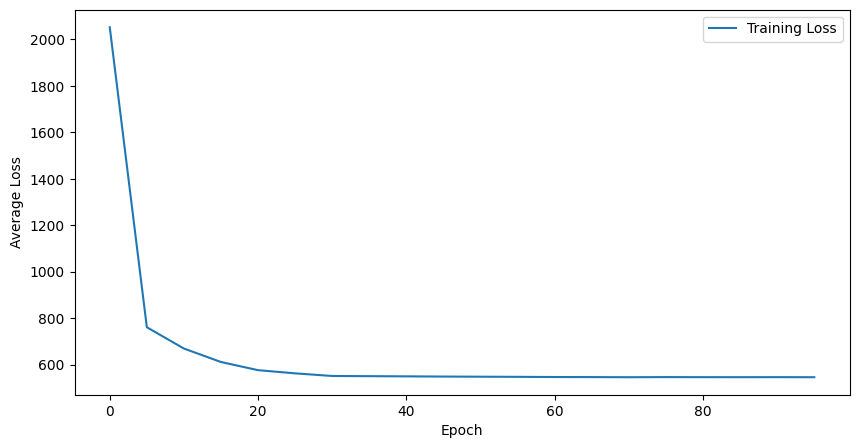

Epoch: 96. Average Loss: 545.6802637997231, Current LR: 1.0000000000000002e-06
Epoch: 97. Average Loss: 545.8267656309007, Current LR: 1.0000000000000002e-06
Epoch: 98. Average Loss: 545.4013956254983, Current LR: 1.0000000000000002e-06
Epoch: 99. Average Loss: 545.6159250823473, Current LR: 1.0000000000000002e-06


In [39]:
ann = ANN(input_size=reg_X_train.shape[1], learning_rate=0.001, epochs=100, batch_size=64, step_size=30, gamma=0.1, random_state=33)
ann.training_step(reg_X_train, reg_y_train)

In [40]:
ann_model_report = ann.evaluate(reg_X_test, reg_y_test, reg_y_test_additional, lambda_)

In [41]:
ann_model_report

[{'name': 'ANN',
  'rmse': 148158.97,
  'mae': 108594.93,
  'r2': -0.1,
  'hit_rate': '72.0%',
  'bias': -78902.734,
  'variance': 453752.72}]

In [45]:
ann_model_report

[{'name': 'ANN',
  'rmse': 148158.97,
  'mae': 108594.93,
  'r2': -0.1,
  'hit_rate': '72.0%',
  'bias': -78902.734,
  'variance': 453752.72}]

In [46]:
elastic_report

[{'name': 'ElasticNet',
  'parameters': {},
  'rmse': 130000.0,
  'mae': 100000.0,
  'r2': -0.0863525146026276,
  'hit_rate': '60.28%',
  'bias': -37000.0,
  'variance': 0.0}]

In [47]:
random_forestrf_reg_report

[{'name': 'RandomForestRegressor',
  'parameters': {},
  'rmse': 120000.0,
  'mae': 88000.0,
  'r2': 0.12270105901388006,
  'hit_rate': '62.44%',
  'bias': -29000.0,
  'variance': 2800000000.0}]

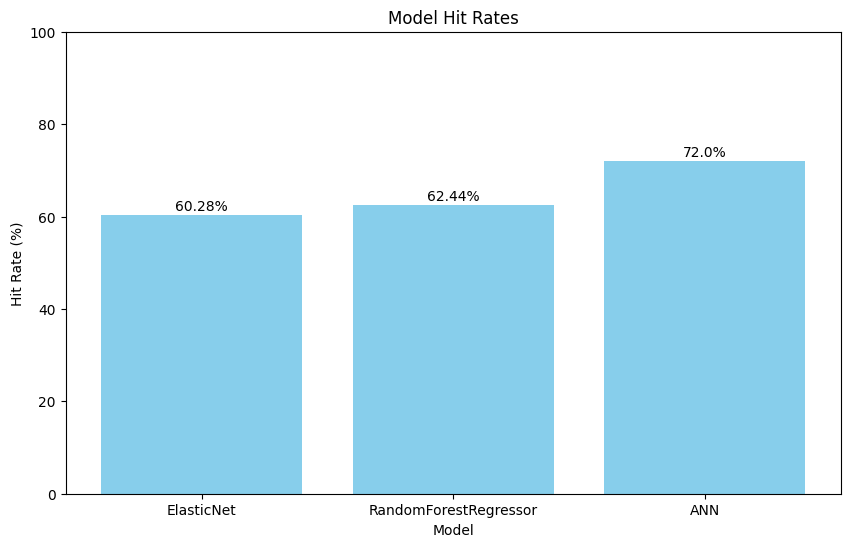

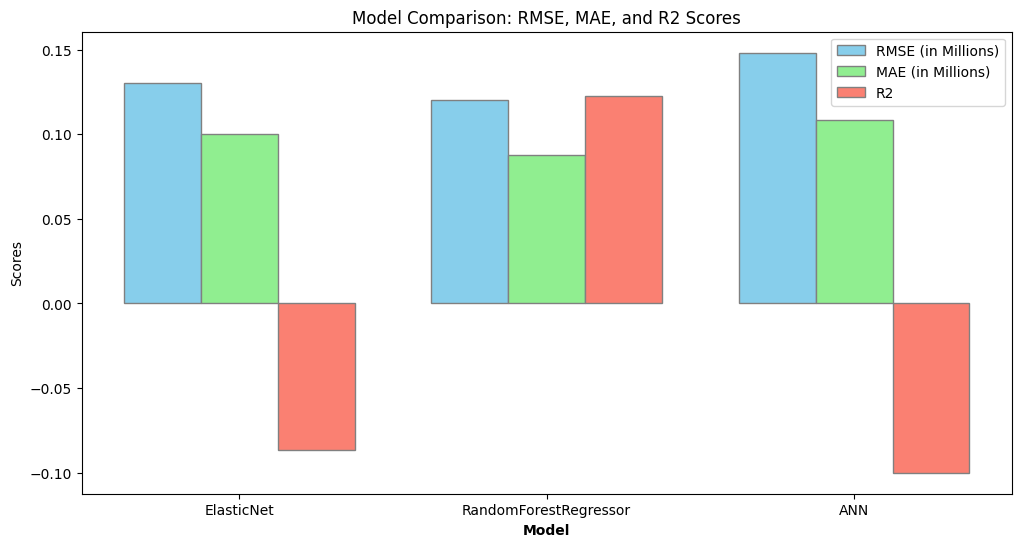

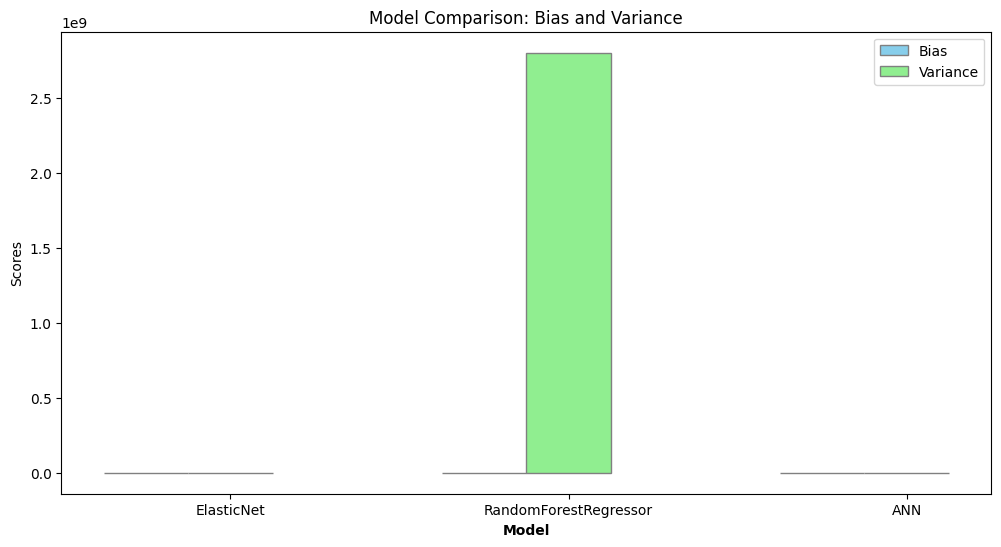

In [42]:
reg_evaluator = Evaluation()
reg_evaluator.add_model_report(elastic_report)
reg_evaluator.add_model_report(random_forestrf_reg_report)
reg_evaluator.add_model_report(ann_model_report)
reg_evaluator.visualize_model_reports(classfy=False)